In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from causalimpact import CausalImpact

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


# 1. Our World in Data COVID-19 확진자 데이터 불러오기

In [3]:
url_owid = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
df_owid = pd.read_csv(url_owid, parse_dates=['date'])

In [5]:
# 대한민국 데이터만 필터링
df_sk = df_owid[df_owid['location'] == 'South Korea'].copy()
# 관심 변수: 일일 신규 확진자(new_cases)를 y로 사용
df_sk = df_sk[['date', 'new_cases']].rename(columns={'new_cases': 'y'})
df_sk = df_sk.set_index('date')

# 2. OxCGRT 정부 대응 데이터 불러오기 (마스크 관련 정책 포함)

In [62]:
df_ox = pd.read_csv('./data/OxCGRT_nat_latest.csv')
# OxCGRT의 Date 열은 YYYYMMDD 형식의 정수이므로 datetime으로 변환
df_ox['date'] = pd.to_datetime(df_ox['Date'], format='%Y%m%d')

In [63]:
# 대한민국 데이터만 필터링
df_ox_sk = df_ox[df_ox['CountryName'] == 'South Korea'].copy()

In [66]:
df_ox_sk['H6M_Facial Coverings'].max()

3.0

In [67]:
# 마스크 정책 지표: H6M_Facial Coverings
# 예시) 정책 수준이 2 이상이면 마스크 의무화 시행으로 간주 (0 또는 1이면 미시행)
df_ox_sk['mask_policy'] = (df_ox_sk['H6M_Facial Coverings'] >= 2).astype(int) 

In [68]:
# date와 mask_policy만 선택하고, index로 설정
df_ox_sk = df_ox_sk[['date', 'mask_policy']].set_index('date')

# 3. 두 데이터셋 병합 (날짜 기준 inner join)

In [69]:
df_merged = pd.merge(df_sk, df_ox_sk, left_index=True, right_index=True, how='inner')
print("병합된 데이터 일부:")
print(df_merged.head())

병합된 데이터 일부:
              y  mask_policy
date                        
2020-01-05  0.0            0
2020-01-06  0.0            0
2020-01-07  0.0            0
2020-01-08  0.0            0
2020-01-09  0.0            0


# 4. 개입(마스크 의무화) 날짜 설정

In [70]:
# mask_policy 1 시작되는 지점 -> 정책 시행 시점
intervention_date = pd.to_datetime(df_merged[df_merged['mask_policy'] == 1].index.min())
print(intervention_date)

2020-05-13 00:00:00


In [87]:
# 분석기간 설정: intervention 전 2개월(2020-03-13 ~ 2020-05-12)과 intervention 후 1개월(2020-05-13 ~ 2020-06-12)
pre_period = [pd.to_datetime('2020-03-13'), intervention_date - pd.Timedelta(days=1)]
post_period = [intervention_date, pd.to_datetime('2022-06-12')]

In [88]:
# 분석에 사용할 시계열 데이터 (여기서는 확진자 수 'y'만 사용)
analysis_data = df_merged[['y']].loc[pre_period[0]:post_period[1]]

# 5. CausalImpact 분석 수행

In [89]:
ci = CausalImpact(analysis_data, pre_period, post_period)
print(ci.summary())
ci.plot()
plt.show()

AttributeError: 'NoneType' object has no attribute 'loc'

에러 발생  
문제: 분석에 사용되는 시계열(여기서는 확진자 수 y)이 모두 0이거나, 변화가 너무 작아 모델이 유의미한 추정을 하지 못할 수도 있습니다.  
해결 방법:  
analysis_data['y']의 분포와 변동성을 확인해보세요.  
너무 낮은 값이나 상수값이면 데이터 전처리(예: 로그 변환 등)를 고려해볼 수 있습니다.  

In [80]:
analysis_data['y'].values

array([   0.,    0., 1028.,    0.,    0.,    0.,    0.,    0.,    0.,
        735.,    0.,    0.,    0.,    0.,    0.,    0.,  686.,    0.,
          0.,    0.,    0.,    0.,    0.,  654.,    0.,    0.,    0.,
          0.,    0.,    0.,  275.,    0.,    0.,    0.,    0.,    0.,
          0.,  149.,    0.,    0.,    0.,    0.,    0.,    0.,   67.,
          0.,    0.,    0.,    0.,    0.,    0.,   65.,    0.,    0.,
          0.,    0.,    0.,    0.,   81.,    0.,    0.,    0.,    0.,
          0.,    0.,  176.,    0.,    0.,    0.,    0.,    0.,    0.,
        140.,    0.,    0.,    0.,    0.,    0.,    0.,  278.,    0.,
          0.,    0.,    0.,    0.,    0.,  308.,    0.,    0.,    0.,
          0.,    0.])

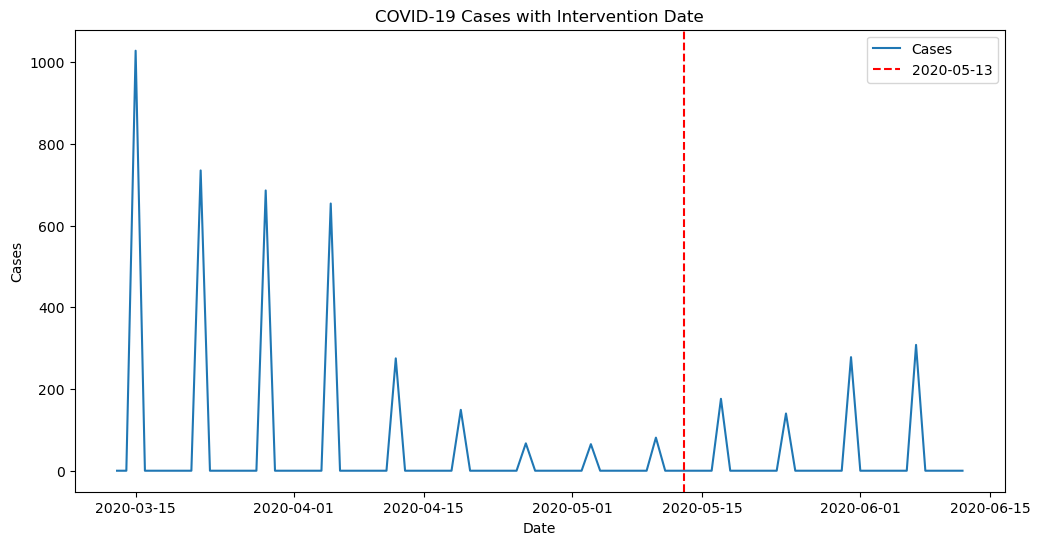

In [74]:
import matplotlib.pyplot as plt
import pandas as pd

# analysis_data의 인덱스가 datetime 형식인지 확인
analysis_data.index = pd.to_datetime(analysis_data.index)

plt.figure(figsize=(12, 6))
plt.plot(analysis_data.index, analysis_data['y'], label='Cases')

# 2020-05-13 날짜에 빨간색 점선 추가
intervention_date = pd.to_datetime("2020-05-13")
plt.axvline(x=intervention_date, color='red', linestyle='--', label='2020-05-13')

plt.xlabel("Date")
plt.ylabel("Cases")
plt.title("COVID-19 Cases with Intervention Date")
plt.legend()
plt.show()


# 결과 해석
- **데이터 병합 확인:**
    - 병합된 데이터의 일부를 보면, 2020년 초에 확진자 수가 0인 데이터가 있으며, 옥스포맷에서 마스크 정책은 0(미시행)으로 기록되어 있습니다.
- **에러 메시지 분석:**
    - `AttributeError: 'NoneType' object has no attribute 'loc'` 에러는 `ci.inferences`가 None이라는 것을 의미합니다.
    - 이는 **모델이 적절하게 학습되지 않거나, 분석에 사용된 전후 기간 내에 충분한(또는 적절한) 데이터가 없어서** 인과 추론 결과가 생성되지 않았음을 시사합니다.
- **종합:**
    - 결과 자체보다는 **분석 과정에 문제가 있었음을** 알 수 있으며, 전후 기간의 데이터 양, 외생적 공변량 선택, 혹은 개입 날짜 설정 등 여러 요인에 따라 모델의 신뢰도가 달라질 수 있습니다.